# Estimation of the MC Needs for the BDT Training
- calculate learning curves for many different masses and regions


# Standard imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

show groups in hdf5 file

In [7]:
import h5py
h5f = h5py.File("/eos/user/j/jglatzer/L2Output_R20_Nov_v2/pandas_allregions.h5", "r")
h5f.keys()

[u'allregions']

In [8]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2/pandas_allregions.h5', 'allregions')

# Number of available events

In [52]:
regions=list(filter(lambda x: "INC" in x, df_mc.region.unique()))
hpmasses_all=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
mcsize={200: 5.5,
        225: 2.0,
        250: 2.0,
        275: 1.5,
        300: 1.5,
        350: 1.3,
        400: 1.2,
        500: 1.1,
        600: 1.0,
        700: 1.0,
        800: 1.0,
        900: 1.0,
        1000: 1.1,
        1200: 1.2,
        1400: 1.5,
        1600: 1.5,
        1800: 2.3,
        2000: 2.3
       }
#mc_6j4b={}
ntarget=20000
#print df_mc.process.unique()
table="<table><tr><td>H<sup>+</sup> mass [GeV]</td><td>MC Nevents</td>"
for region in regions:
    table+="<td>"+region+"</td>"
table+="<td>Ideal MC size</td></tr>"
for hpmass in hpmasses_all:
    table+="<tr><td>"+str(hpmass)+"</td><td>"+str(mcsize[hpmass])+"M</td>"
    for region in regions:
        mask=(df_mc.region==region) & (df_mc.process=="Hp"+str(hpmass))
        shape=df_mc[mask].shape
        table+="<td>"+str(shape[0])+"</td>"
        if region=="INC_ge6jge4b":
            table+="<td>"+"{:.1f}".format(mcsize[hpmass]*ntarget/shape[0])+"M</td>"
    table+="</tr>"
table+="</table>"
from IPython.display import HTML, display
display(HTML(table))

H+ mass [GeV],MC Nevents,INC_5j3b,INC_5jge4b,INC_ge6j3b,INC_ge6jge4b,Ideal MC size
200,5.5M,61732,6645,74559,17049,6.5M
225,2.0M,33460,4272,41370,11170,3.6M
250,2.0M,38822,4997,50130,14040,2.8M
275,1.5M,31410,4099,43448,12136,2.5M
300,1.5M,43909,5733,64471,18179,1.7M
350,1.3M,28926,3831,46394,13016,2.0M
400,1.2M,25922,3291,45480,13025,1.8M
500,1.1M,24440,3182,50377,14475,1.5M
600,1.0M,21198,2726,51081,14616,1.4M
700,1.0M,20038,2540,54882,15908,1.3M


MC events is the number of events before any cuts (no weights applied), the other columns the number of signal events in each of the signal regions, ideal MC size is the size if we ask for 20k events in 6j4b

# Prepare data for H+ classification

split into test and training data

In [30]:
regions=['INC_5j3b', 'INC_5jge4b','INC_ge6j3b','INC_ge6jge4b']
hpmasses_all=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
hpmasses=hpmasses_all[0::4]
#for region in regions:
#    df_mc[region]=df_mc_all[df_mc_all.region==region]
#    print region, df_mc[region].shape

In [31]:
print hpmasses
#clf=HpAlgorithms.getGradientBDTClassifier()#options={"n_estimators":10})

[200, 300, 600, 1000, 1800]


In [32]:
train_sizes=np.linspace(0.2,1,5)
all_train_scores={}
all_test_scores={}
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
for region in regions:
    print "Looking at region", region
    all_train_scores[region]={}
    all_test_scores[region]={}
    for hpmass in hpmasses:
        print "   Looking at hpmass=",hpmass
        X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass,region=region)
        #print hpmass, X_train.shape, X_test.shape, X_eval.shape, y_train.shape, y_test.shape, y_eval.shape, w_train.shape, w_test.shape, w_eval.shape
        clf=HpAlgorithms.getGradientBDTClassifier()
        opt=HpHyperParameterOptimisation.HpOptimise("StandardBDT"+region+"Hp"+str(hpmass),clf,X_train,y_train,w_train,X_test,y_test,w_test)
        _, train_scores, test_scores = opt.calculateLearningCurve(train_sizes=train_sizes, category=1) #sample only signal events
        all_train_scores[region][hpmass]=train_scores
        all_test_scores[region][hpmass]=test_scores

Looking at region INC_5j3b
   Looking at hpmass= 200
   Looking at hpmass= 300
   Looking at hpmass= 600
   Looking at hpmass= 1000
   Looking at hpmass= 1800
Looking at region INC_5jge4b
   Looking at hpmass= 200
   Looking at hpmass= 300
   Looking at hpmass= 600
   Looking at hpmass= 1000
   Looking at hpmass= 1800
Looking at region INC_ge6j3b
   Looking at hpmass= 200
   Looking at hpmass= 300
   Looking at hpmass= 600
   Looking at hpmass= 1000
   Looking at hpmass= 1800
Looking at region INC_ge6jge4b
   Looking at hpmass= 200
   Looking at hpmass= 300
   Looking at hpmass= 600
   Looking at hpmass= 1000
   Looking at hpmass= 1800


In [33]:
print all_train_scores
print all_test_scores

{'INC_5j3b': {200: [0.25753328960971944, 0.28229099737812235, 0.2911356831060812, 0.2969331251372521, 0.3010333052457106], 600: [0.07724107475286435, 0.08879457042749173, 0.09310421988135953, 0.09402949666681837, 0.09477901677862066], 300: [0.22024052440275455, 0.2484859184403838, 0.26408538840680074, 0.27320793455053816, 0.277194335160563], 1000: [0.02808568763575192, 0.029958459275567062, 0.02896536929341642, 0.029999154849403187, 0.029900308017255295], 1800: [0.008169459488206687, 0.008297598517862603, 0.0073011112581865545, 0.007195548698202492, 0.00731459351096253]}, 'INC_ge6j3b': {200: [0.25541183208073714, 0.28399313794490166, 0.2894547833425558, 0.2976419380063732, 0.302365970137799], 600: [0.13271060134693513, 0.14705583679395484, 0.15156252845507223, 0.15343300701083518, 0.1554620562992317], 300: [0.2532532800815078, 0.2779923168154529, 0.2912918689168682, 0.301466275412689, 0.3062023982852238], 1000: [0.05817314638193449, 0.06214784906994919, 0.06355054391473969, 0.063278958

## draw the learning curve

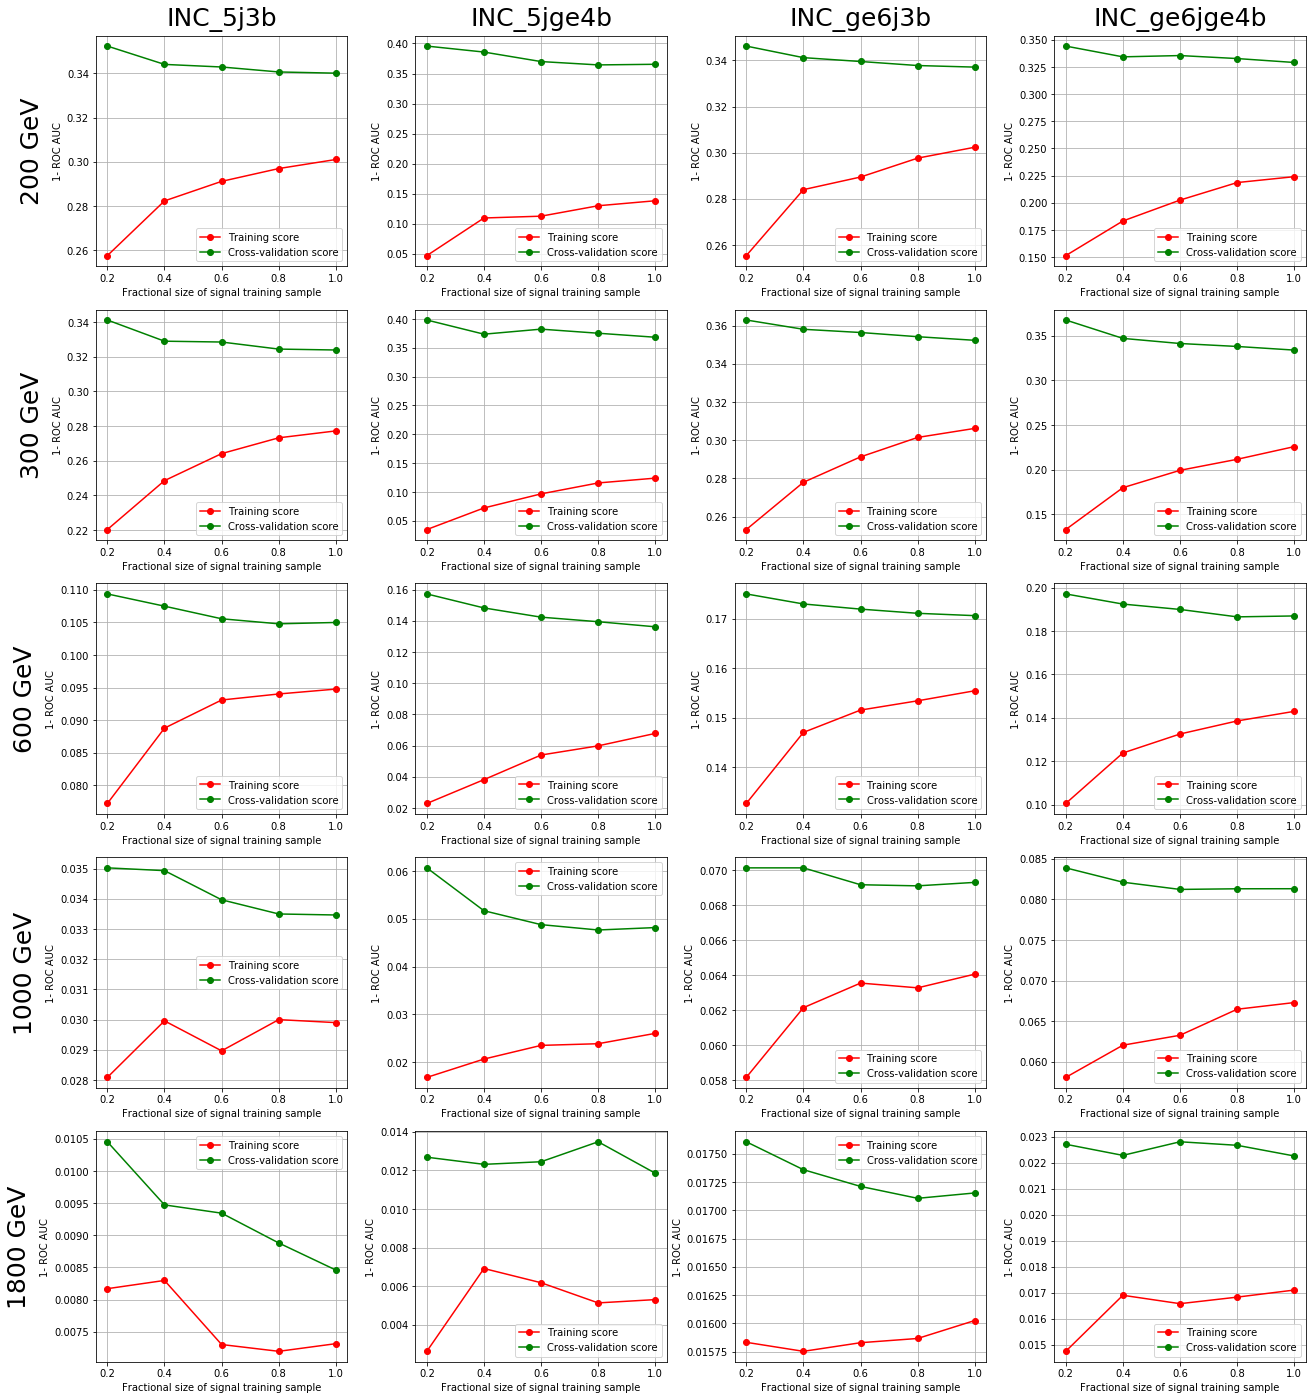

In [111]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

fig, axes = plt.subplots(nrows=len(hpmasses), ncols=len(regions), figsize=(20, 20))#, sharex='col',sharey='row')
#fig.set_xlabel('Fractional size of signal training sample')
#fig.set_ylabel("1-ROC AUC")

for i, mass in enumerate(hpmasses):
    for j, region in enumerate(regions):
        axes[i][j].plot(train_sizes, all_train_scores[region][mass], 'o-', color="r",
                 label="Training score")
        axes[i][j].plot(train_sizes, all_test_scores[region][mass], 'o-', color="g",
                 label="Cross-validation score")
        axes[i][j].set_xlabel('Fractional size of signal training sample')
        axes[i][j].set_ylabel("1- ROC AUC")
        axes[i][j].legend(loc=0)
        axes[i][j].grid()
        #plt.title(region+" mHp="+str(mass), fontsize=10)

pad = 5 # in points

for ax, col in zip(axes[0], regions):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad*2),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline', fontsize=25)

for ax, row in zip(axes[:,0], hpmasses):
    ax.annotate(str(row)+" GeV", xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center',rotation=90, fontsize=25)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

plt.show()

It should be noted that 1-ROC AUC is shown here so small effects (e.g. 2 per mille) will have a significant effect on the cross-section limit.